# Run the wavelength and the fringe frame maker notebooks first!

In [1]:
import os
os.environ['OPENTSDB_PYTHON_METRICS_TEST_MODE'] = 'True'

In [2]:
import importlib.resources
import requests
from banzai_floyds import settings
from banzai.utils.stage_utils import run_pipeline_stages
from banzai.utils.fits_utils import download_from_s3
import numpy as np
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy import units
from matplotlib import pyplot
from glob import glob
import tarfile

In [3]:
os.environ['DB_ADDRESS'] = 'sqlite:///test_data/test.db'
settings.processed_path= os.path.join(os.getcwd(), 'test_data')
settings.fpack=True
settings.db_address = os.environ['DB_ADDRESS']
settings.RAW_DATA_FRAME_URL = f'https://archive-api.lco.global/frames'

In [4]:
# set up the context object.
import banzai.main
context = banzai.main.parse_args(settings, parse_system_args=False)

In [5]:
from banzai_floyds import dbs

In [6]:
dbs.ingest_standards(settings.db_address)

In [7]:
# Start with just the profile.
context = banzai.main.parse_args(settings, parse_system_args=False)

In [8]:
from banzai_floyds.tests.test_e2e import is_standard
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
for row in test_data:
    if 'e00.fits' in row['filename'] and is_standard(row['object']):
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

2024-02-16 15:07:05.831     INFO:      fits_utils: Downloading file coj2m002-en12-20200813-0026-e00.fits.fz from archive. ID: 33852323. | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2024-02-16 15:07:07.791     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207853", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-02-16 15:07:07.794     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207853", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-02-16 15:07:07.794     INFO:            trim: Trimming image | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument

In [9]:
def fits_header_to_wavelength(header):
    crval = float(header['CRVAL1'])
    crpix = float(header['CRPIX1'])
    # Convert crpix to be zero indexed
    crpix -= 1
    if 'CDELT1' in header.keys():
        cdelt = float(header['CDELT1'])
    else:
        cdelt = float(header['CD1_1'])
    npix = float(header['NAXIS1'])
    lam = np.arange(crval - cdelt * crpix ,
                    crval + cdelt * (npix - crpix) - 1e-4,
                    cdelt)
    return lam

coj2m002-en12-20200813-0026-e91-1d.fits.fz


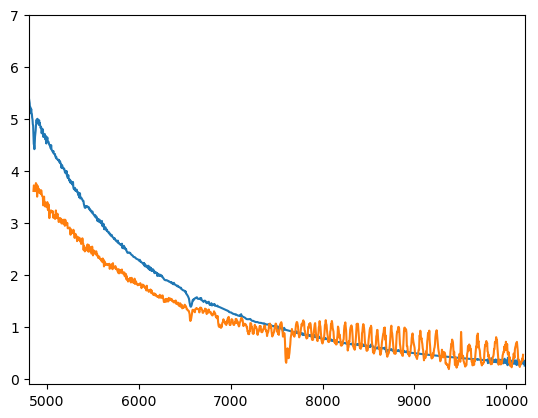

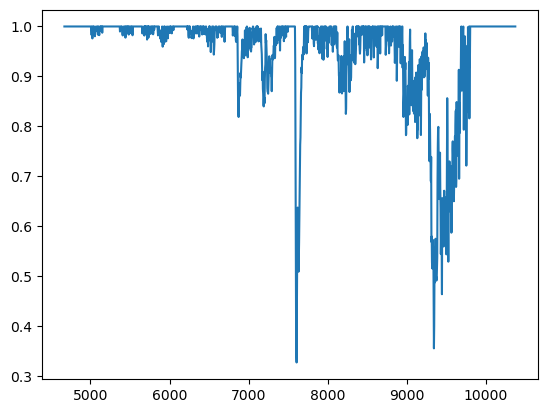

coj2m002-en12-20200813-0026-e91-1d.fits.fz


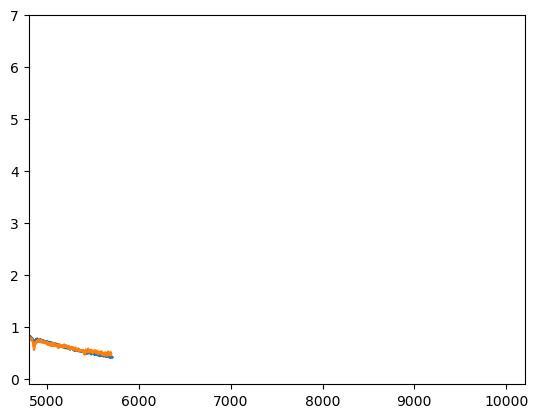

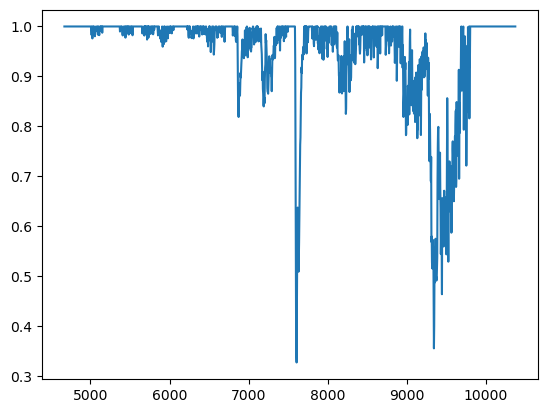

ogg2m001-en06-20200822-0007-e91-1d.fits.fz


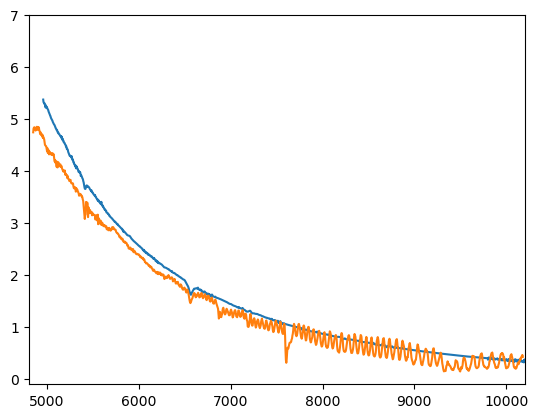

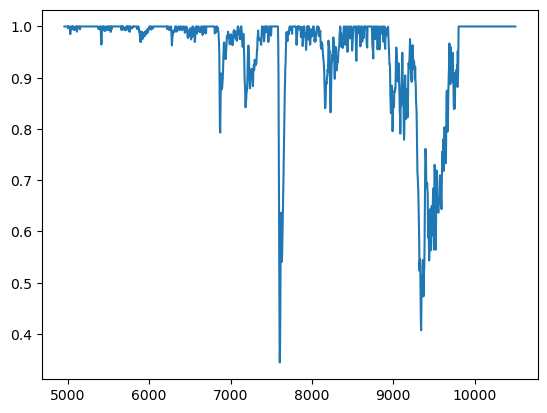

ogg2m001-en06-20200822-0007-e91-1d.fits.fz


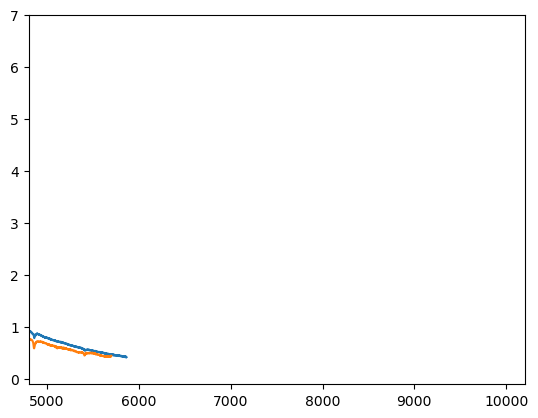

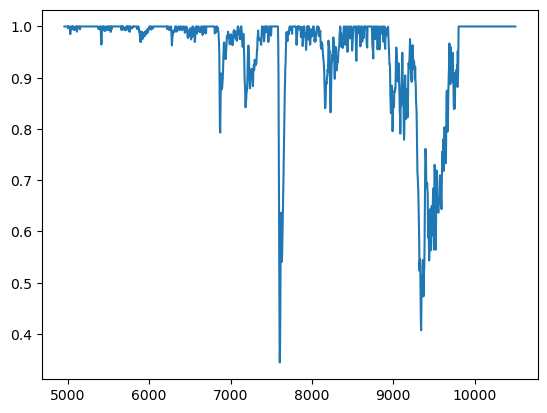

In [10]:
orders_to_color = {1: 'red', 2: 'blue'}

# Untar and extract the arc file
for filename in glob('test_data/*.tar.gz'):
    with tarfile.open(filename, 'r:gz') as f:
        for file_to_extract in f.getnames():
            if 'ttarc' == file_to_extract[:5]:
                f.extract(file_to_extract, os.path.join(os.getcwd(), 'test_data'))

tar_filenames = glob('test_data/*.tar.gz')

# plot the raw flux against the old pipeline's extractions
for row in test_data:
    if 'e00.fits' in row['filename'] and is_standard(row['object']):
        spectrum = glob(f'./test_data/*/*/*/processed/{row["filename"].replace("e00", "e91").replace(".fits", "-1d.fits")}')[0]
        hdu = fits.open(spectrum)
        site = row['filename'][:3]
        for tar_filename in tar_filenames:
            if os.path.basename(tar_filename)[:3].lower() == site:
                with tarfile.open(tar_filename, 'r:gz') as f:
                    for file_to_extract in f.getnames():
                        if 'ex.fits' in file_to_extract:
                            f.extract(file_to_extract, os.path.join(os.getcwd(), 'test_data'))
        for i in range(1, 3):
            in_order = hdu['SPECTRUM'].data['order'] == i
            data = hdu['SPECTRUM'].data
            data_to_plot = data['flux'][in_order]
            data_to_plot /= np.median(data_to_plot)
            pyplot.plot(data['wavelength'][in_order], data_to_plot)

            hdu[0].header['OBJECT'].upper()
            print(os.path.basename(spectrum))

            # get the old pipeline equivalent
            old_extraction = glob(f'test_data/tt{hdu[0].header["OBJECT"].upper()}*{orders_to_color[i]}*_ex.fits*')[0]
            old_hdu = fits.open(old_extraction)
            iraf_wavelengths = fits_header_to_wavelength(old_hdu[0].header)
            iraf_data_plot = old_hdu[0].data[0, :].T
            iraf_data_plot /= np.median(iraf_data_plot)
            pyplot.plot(iraf_wavelengths, old_hdu[0].data[0, :].T)
            pyplot.xlim(4800, 10200)
            pyplot.ylim(-0.1, 7)
            pyplot.show()
            pyplot.plot(hdu['TELLURIC'].data['wavelength'], hdu['TELLURIC'].data['telluric'])
            pyplot.show()

In [11]:
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
for row in test_data:
    if 'e00.fits' in row['filename'] and not is_standard(row['object']):
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

2024-02-16 15:10:12.578     INFO:      fits_utils: Downloading file coj2m002-en12-20200813-0014-e00.fits.fz from archive. ID: 33851447. | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2024-02-16 15:10:14.570     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-02-16 15:10:14.573     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-02-16 15:10:14.573     INFO:            trim: Trimming image | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument

In [12]:
from glob import glob
from astropy.io import fits

In [13]:
extracted_spectra = glob('./test_data/*/*/*/processed/*-1d.fits.fz')

ogg2m001-en06-20200822-0027-e91-1d.fits.fz HD 201767


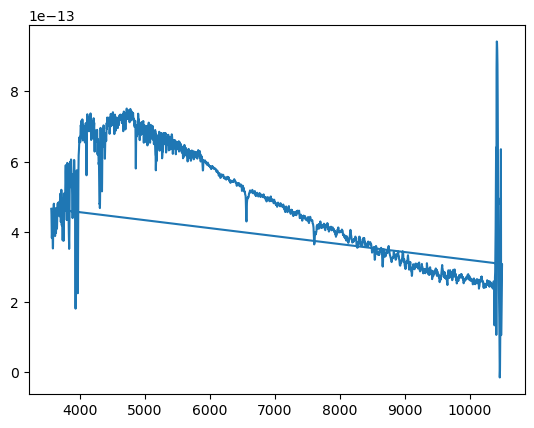

ogg2m001-en06-20200822-0007-e91-1d.fits.fz BD+284211


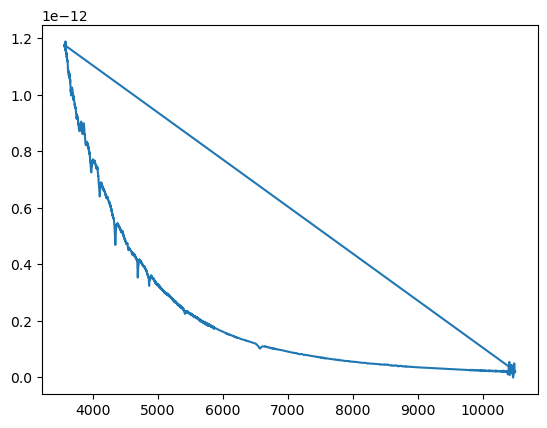

coj2m002-en12-20200813-0014-e91-1d.fits.fz SN2020llx


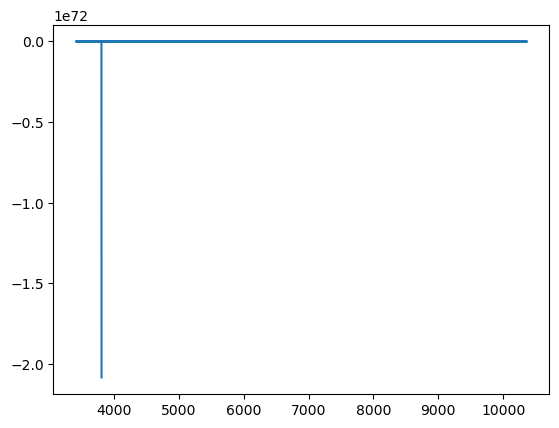

coj2m002-en12-20200813-0026-e91-1d.fits.fz FEIGE110


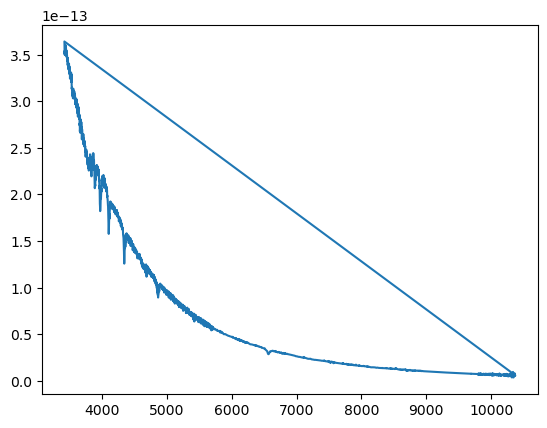

In [14]:
#for f in extracted_spectra:
for f in extracted_spectra:
    hdu = fits.open(f)
    pyplot.plot(hdu[1].data['wavelength'], hdu[1].data['flux'])
    print(os.path.basename(f), hdu[0].header['OBJECT'])
    pyplot.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

f = extracted_spectra[3]
hdu = fits.open(f)

fig = go.Figure(data={'x': hdu[1].data['wavelength'], 'y': hdu[1].data['fluxraw']})
fig.show()